# IMO zadanie 7 - Własna metoda
ILS, greedy cycle, usuwanie wierzchołków trójkami

Emilia Maciejewska 136764<br>

In [1]:
import tsplib95
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import datetime
import statistics

## 0. Wczytywanie danych

In [2]:
problemA = tsplib95.load("kroA200.tsp")
problemA = problemA.as_keyword_dict()

In [3]:
problemB = tsplib95.load("kroB200.tsp")
problemB = problemB.as_keyword_dict()

In [4]:
def create_distance_matrix(data):
    dict_length = len(data['NODE_COORD_SECTION'])
    distance_matrix = np.zeros((dict_length, dict_length), dtype=int)
    for i in range(len(distance_matrix)):
        for j in range(len(distance_matrix[i])):
            x1 = data['NODE_COORD_SECTION'][i+1]
            x2 = data['NODE_COORD_SECTION'][j+1]
            d = math.floor(math.sqrt((x1[0]-x2[0])**2 + (x1[1]-x2[1])**2) + 0.5)
            distance_matrix[i][j] = d
    return distance_matrix

In [5]:
distance_matrix_A = create_distance_matrix(problemA)
distance_matrix_B = create_distance_matrix(problemB)

## 1. Algorytm startowy

In [6]:
def selectStartingPoints(id):
    if id == 'A':
        max_id = max_id = len(distance_matrix_A) - 1 
    else:
        max_id = max_id = len(distance_matrix_B) - 1 
    p1 = random.randint(0, max_id)
    p2 = random.randint(0, max_id)
    while p2 == p1:
        p2 = random.randint(0, max_id)
    return p1, p2

In [7]:
def selectP(experimentId):
    p1 = 0
    p2 = 0
    while True:
        p1, p2 = selectStartingPoints(experimentId)
        sId1 = str(p1)+","+str(p2)
        sId2 = str(p2)+","+str(p1)
        if sId1 not in startingPoints and sId2 not in startingPoints:
            startingPoints[sId1] = 1
            break
    return p1, p2

In [8]:
def find_first_cycle(experimentId, p, matrix_length, selected):
    
    d_matrix = []
    if experimentId == 'A':
        d_matrix = distance_matrix_A 
    else:
        d_matrix = distance_matrix_B
    minV = np.inf
    minId = p
    for i in range(matrix_length):
        if i not in selected:
            if d_matrix[p][i] < minV:
                minV = d_matrix[p][i]
                minId = i
    return minV, minId

In [9]:
def greedy_start(experimentId, p1, p2):
    matrix_length = 0
    d_matrix = []
    if experimentId == 'A':
        matrix_length = len(distance_matrix_A) 
        d_matrix = distance_matrix_A
    else:
        matrix_length = len(distance_matrix_B)  
        d_matrix = distance_matrix_B
        
    selected = dict()
    selected[p1] = 1
    selected[p2] = 1
    result = [[p1],[p2]]
    resultVal = [[0],[0]]
    
    minV, minId1 = find_first_cycle(experimentId, p1, matrix_length, selected)
    selected[minId1] = 1
    result[0].append(minId1)
    resultVal[0] = minV

    minV, minId = find_first_cycle(experimentId, p2, matrix_length, selected)
    selected[minId] = 1
    result[1].append(minId)
    resultVal[1] = minV    
    
    notSelected = []
    for j in range (matrix_length):
        if j != p1 and j != p2 and j != minId1 and j != minId:
            notSelected.append(j)

    cycleId = 0
    while len(selected) < matrix_length:
        newDist = np.inf
        newArr = []
        newItem = np.inf
        
        random.shuffle(notSelected)
        pr = math.ceil(len(notSelected)*0.1)
        
        for i in range(pr):
            if notSelected[i] not in selected:
                for j in range(len(result[cycleId])+1):
                    new = result[cycleId][:j]
                    new.append(notSelected[i])
                    new += result[cycleId][j:]
                    dist = 0
                    for k in range(1, len(new)):
                        dist += d_matrix[new[k-1]][new[k]]
                    dist += d_matrix[new[len(new) - 1]][new[0]]
                    if dist < newDist:
                        newDist = dist
                        newArr = new
                        newItem = notSelected[i]
        result[cycleId] = newArr
        resultVal[cycleId] = newDist
        selected[newItem] = 1
        notSelected.remove(newItem)
        if cycleId == 0:
            cycleId = 1
        else:
            cycleId = 0
    result[0].append(result[0][0])
    result[1].append(result[1][0])
    return result, resultVal

## 2. Lokalne przeszukiwanie w wersji stromej (wierzchołki + krawędzie)

### 2.1 Sąsiedztwo międzytrasowe wierzchołki

In [10]:
def neighborExternalV (experimentId, result):
    mat = distance_matrix_A if experimentId == 'A' else distance_matrix_B
    delta = np.inf
    r = []
    aA = np.copy(result[0])
    aB = np.copy(result[1])
    aA = np.append(aA, aA[1])
    aB = np.append(aB, aB[1]) 
    for i in range(1, len(aA)-1):
        for j in range(1, len(aB)-1):
            dis1 = mat[aA[i-1]][aA[i]] + mat[aA[i]][aA[i+1]]
            dis1 += mat[aB[j-1]][aB[j]] + mat[aB[j]][aB[j+1]]
            dis2 = mat[aB[j-1]][aA[i]] + mat[aA[i]][aB[j+1]]
            dis2 += mat[aA[i-1]][aB[j]] + mat[aB[j]][aA[i+1]]
            d = dis2 - dis1
            if d < delta:
                delta = d
                r = [aA[i], aB[j]]
    return delta, r

### 2.2 Sąsiedztwo wewnątrztrasowe krawędzie

In [11]:
def neighborInternalESingle (mat, aA, delta, r):
    for i in range(1, len(aA)):
        for j in range(i+1,  len(aA)-1):
            if i+1 != j:
                dis1 = mat[aA[i-1]][aA[i]] + mat[aA[j]][aA[j+1]]
                dis2 = mat[aA[i-1]][aA[j]] + mat[aA[i]][aA[j+1]]
                d = dis2 - dis1
                if d < 0 and d < delta:
                    delta = d
                    r = [aA[i], aA[j]]
    return delta, r

In [12]:
def neighborInternalE (experimentId, result):
    mat = distance_matrix_A if experimentId == 'A' else distance_matrix_B
    delta = np.inf
    r = []
    aA = np.copy(result[0])
    aB = np.copy(result[1])
    delta1, r1 = neighborInternalESingle(mat, aA, delta, r)
    delta2, r2 = neighborInternalESingle(mat, aB, delta, r)
    if delta1 < delta2:
        return delta1, r1, "0"
    else:
        return delta2, r2, "1"

### 2.3 Lokalne przeszukiwanie

In [13]:
def steepestE (experimentId, result, resultVal):
    mat = distance_matrix_A if experimentId == 'A' else distance_matrix_B
    delta = -1
    r = []
    
    while delta < 0:
        newResult = [[],[]]
        newResultVal = [0, 0]
        delta1, r1 = neighborExternalV(experimentId, result)
        delta2, r2, cycleId = neighborInternalE(experimentId, result)
        if delta1 < delta2: # lepsza była zmiana międzytrasowa
            r = r1
            for i in range(len(result)):
                for j in range(len(result[i])):
                    if i == 0 and result[i][j] == r[0]:
                        newResult[i].append(r[1])
                    elif i == 1 and result[i][j] == r[1]:
                        newResult[i].append(r[0])
                    else:
                        newResult[i].append(result[i][j])
                    if len(newResult[i]) > 1:
                        newResultVal[i] += mat[newResult[i][-2]][newResult[i][-1]]
        else:
            r = r2
            tempA = []
            cycleId = int(cycleId)
            index1 = np.where(result[cycleId] == r[0])
            index2 = np.where(result[cycleId] == r[1])
            tempA = np.copy(result[cycleId])
            tempA = tempA[index1[0][0]+1: index2[0][0]]
            
            if cycleId == 1:
                newResultVal[0] = np.copy(resultVal[0])
                newResult[0] = np.copy(result[0])
            else:
                newResultVal[1] = np.copy(resultVal[1])
                newResult[1] = np.copy(result[1])
            
            tempA = np.flip(tempA)
            flag = False
            ind = 0
            for j in range(len(result[cycleId])):
                if result[cycleId][j] == r[0]:
                    newResult[cycleId].append(r[1])
                    ind = 0
                    flag = True
                elif result[cycleId][j] == r[1]:
                    newResult[cycleId].append(r[0])
                    flag = False
                elif flag == True:
                    newResult[cycleId].append(tempA[ind])
                    ind +=1
                else:
                    newResult[cycleId].append(result[cycleId][j])
                if len(newResult[cycleId]) > 1:
                    newResultVal[cycleId] += mat[newResult[cycleId][-2]][newResult[cycleId][-1]]

        delta = newResultVal[0] + newResultVal[1] - resultVal[0] - resultVal[1]
        result = np.copy(newResult)
        resultVal = np.copy(newResultVal)
        
    return result, resultVal

## 5. Iterated local search (ILS2)

**Iteracyjne przeszukiwanie lokalne z Large-scale neighborhood search**

In [34]:
def destroy(result):
    aA = np.copy(result[0][:-1])
    aB = np.copy(result[1][:-1])
    pA = np.arange(0, len(aA)-3, 3)
    pB = np.arange(0, len(aB)-3, 3)
    np.random.shuffle(pA)
    np.random.shuffle(pB)
    partA = pA[0:7]
    partB = pB[0:7]
    partA1 = partA + 1
    partB1 = partB + 1
    partA2 = partA + 2
    partB2 = partB + 2
    fullA = np.concatenate((partA, partA1, partA2), axis=None)
    fullB = np.concatenate((partB, partB1, partB2), axis=None)
    fullA = np.sort(fullA) 
    fullB = np.sort(fullB)
    new_aA = np.delete(aA, fullA)
    new_aB = np.delete(aB, fullB)
    
    return [new_aA, new_aB]

In [15]:
def repair(experimentId, result):
    mat = distance_matrix_A if experimentId == 'A' else distance_matrix_B
    matrix_length = len(mat)

    selected = dict()
    for i in range(len(result)):
        for j in range(len(result[i])):
            selected[result[i][j]] = 1
    resultVal = [[0],[0]]
    
    cycleId = 0
    while len(selected) < matrix_length:
        newDist = np.inf
        newArr = []
        newItem = np.inf
        for i in range(matrix_length):
            if i not in selected:
                for j in range(len(result[cycleId])+1):
                    new = result[cycleId][:j]
                    new = np.append(new, i)
                    new = np.concatenate((new, result[cycleId][j:]))
                    dist = 0
                    for k in range(1, len(new)):
                        dist += mat[new[k-1]][new[k]]
                    dist += mat[new[len(new) - 1]][new[0]]
                    if dist < newDist:
                        newDist = dist
                        newArr = new
                        newItem = i
        result[cycleId] = newArr
        resultVal[cycleId] = newDist
        selected[newItem] = 1
        if cycleId == 0:
            cycleId = 1
        else:
            cycleId = 0
    result[0] = np.append(result[0], result[0][0])
    result[1] = np.append(result[1], result[1][0])
    return result, resultVal

In [16]:
def ils2a(experimentId, p1, p2, t):
    start_time = datetime.datetime.now()
    start, startVal = greedy_start(experimentId, p1, p2)
    bestR, bestV = steepestE(experimentId, start, startVal)
    end_time = datetime.datetime.now()
    time_diff = (end_time - start_time)
    e_t = time_diff.total_seconds() * 1000
    while e_t < t:
        pD = destroy(bestR)
        pRr, pRv = repair(experimentId, pD)
        newR, newV = steepestE(experimentId, pRr, pRv)
        if newV[0]+newV[1] < bestV[0]+bestV[1]:
            bestR = newR
            bestV = newV
        end_time = datetime.datetime.now()
        time_diff = (end_time - start_time)
        e_t = time_diff.total_seconds() * 1000
    return bestR, bestV[0]+bestV[1], e_t  

In [17]:
def ils2c(experimentId, p1, p2, t):
    start_time = datetime.datetime.now()
    start, startVal = greedy_start(experimentId, p1, p2)
    bestR, bestV = steepestE(experimentId, start, startVal)
    end_time = datetime.datetime.now()
    time_diff = (end_time - start_time)
    e_t = time_diff.total_seconds() * 1000
    while e_t < t:
        pD = destroy(bestR)
        newR, newV = repair(experimentId, pD)
        if newV[0]+newV[1] < bestV[0]+bestV[1]:
            bestR = newR
            bestV = newV
        end_time = datetime.datetime.now()
        time_diff = (end_time - start_time)
        e_t = time_diff.total_seconds() * 1000
    return bestR, bestV[0]+bestV[1], e_t 

## 6. Przygotowanie wyników

In [18]:
problemA['NODE_COORD_SECTION']
dataA = []
for i in range(1, len(problemA['NODE_COORD_SECTION'])+1):
    dataA.append(problemA['NODE_COORD_SECTION'][i])
dataArrA = np.array(dataA)

In [19]:
problemB['NODE_COORD_SECTION']
dataB = []
for i in range(1, len(problemB['NODE_COORD_SECTION'])+1):
    dataB.append(problemB['NODE_COORD_SECTION'][i])
dataArrB = np.array(dataB)

In [20]:
def print_plot(data, points, title, fileName):
    f = plt.figure()
    plt.plot(data[:, 0], data[:, 1], "o", linewidth=0, alpha=0.4)
    plt.plot(data[points[0], 0], data[points[0], 1], "o", color='tab:blue',  linewidth=0, alpha=0.6)
    plt.plot(data[points[0], 0], data[points[0], 1], "--", color="tab:cyan", linewidth=1, alpha=2)
    plt.plot(data[points[1], 0], data[points[1], 1], "o", color='tab:red',  linewidth=0, alpha=0.6)
    plt.plot(data[points[1], 0], data[points[1], 1], "--", color="tab:orange", linewidth=1, alpha=2)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(title)
    plt.grid(False)
    
    plt.show()
    f.savefig(fileName, bbox_inches='tight')

In [21]:
def summarizeStart(result, resultVal, title, dataArr):
    valueArray = np.array(resultVal)
    print("wyniki algorytmu")
    print("min", np.min(valueArray))
    print("max", np.max(valueArray))
    print("mean", np.mean(valueArray))
    index = np.argmin(valueArray)
    print_plot(dataArr, result[index], title, title + ".png")
    plt.show()

In [22]:
def summarize(result, resultVal, timeT, title, dataArr):
    valueArray = np.array(resultVal)
    timeArray = np.array(timeT)
    print("wyniki algorytmu")
    print("min", np.min(valueArray))
    print("max", np.max(valueArray))
    print("mean", np.mean(valueArray))
    index = np.argmin(valueArray)
    print(index)
    print(valueArray)
    print("czas obliczeń")
    print("min", np.min(timeArray))
    print("max", np.max(timeArray))
    print("mean", np.mean(timeArray))
    print_plot(dataArr, result[index], title, title + ".png")
    plt.show()

## 7. Eksperyment A

In [35]:
resultS = []
resultSV = []

result1 = []
resultVal1 = []
time1 = []

result2 = []
resultVal2 = []
time2 = []
startingPoints = dict()

In [36]:
def runILS2a(experimentId):
    m_t = 365000
    itersNumber = 10    
    for i in range(itersNumber):
        print("nr iteracji", i)
        #ils2
        p1, p2 = selectP(experimentId)
        r,v,t = ils2a(experimentId, p1, p2, m_t)
        print(v)
        result4.append(r)
        resultVal4.append(v)
        time4.append(t) 

nr iteracji 0
32428
nr iteracji 1
31602
nr iteracji 2
31046
nr iteracji 3
31704
nr iteracji 4
32202
nr iteracji 5
31715
nr iteracji 6
32465
nr iteracji 7
31939
nr iteracji 8
33026
nr iteracji 9
32162
wyniki algorytmu
min 31046
max 33026
mean 32028.9
2
[32428 31602 31046 31704 32202 31715 32465 31939 33026 32162]
czas obliczeń
min 365065.531
max 373059.485
mean 368941.0108


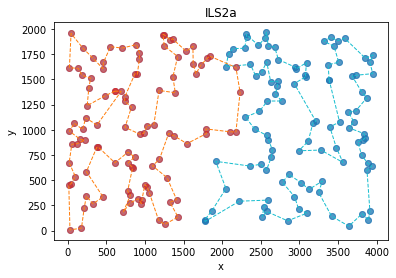

In [37]:
result4 = []
resultVal4 = []
time4 = []
startingPoints = dict()

runILS2a('A')
summarize(result4, resultVal4, time4, "ILS2a", dataArrA)

In [38]:
def runILS2c(experimentId):
    m_t = 365000

    itersNumber = 10    
    for i in range(itersNumber):
        print("nr iteracji", i)
        #ils2
        p1, p2 = selectP(experimentId)
        r,v,t = ils2c(experimentId, p1, p2, m_t)
        print(v)
        result6.append(r)
        resultVal6.append(v)
        time6.append(t) 

nr iteracji 0
35593
nr iteracji 1
34583
nr iteracji 2
35038
nr iteracji 3
32346
nr iteracji 4
33374
nr iteracji 5
33695
nr iteracji 6
33988
nr iteracji 7
31770
nr iteracji 8
33208
nr iteracji 9
34647
wyniki algorytmu
min 31770
max 35593
mean 33824.2
7
[35593 34583 35038 32346 33374 33695 33988 31770 33208 34647]
czas obliczeń
min 365666.19100000005
max 372158.44499999995
mean 368455.442


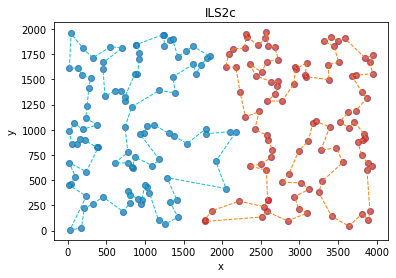

In [39]:
result6 = []
resultVal6 = []
time6 = []
startingPoints = dict()

runILS2c('A')
summarize(result6, resultVal6, time6, "ILS2c", dataArrA)

## 8. Eksperyment B

In [ ]:
result4 = []
resultVal4 = []
time4 = []
startingPoints = dict()

runILS2a('B')
summarize(result4, resultVal4, time4, "ILS2a_B", dataArrB)

In [ ]:
result6 = []
resultVal6 = []
time6 = []
startingPoints = dict()

runILS2c('B')
summarize(result6, resultVal6, time6, "ILS2c_B", dataArrB)